# SpotFake: Twitter Fake News Detection - Training & Inference

This notebook provides a clean implementation for:
1. Loading and preprocessing data (text + images)
2. Building the multimodal model (BERT + VGG19)
3. Training the model
4. Making predictions on new inputs (text + image)

In [25]:
# !python -m venv .venv
# !.venv\Scripts\Activate.ps1
# !pip install -r requirements.txt

## 1. Imports and Setup

In [68]:
import os
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
tqdm.pandas()
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
from os import listdir
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

import tensorflow as tf
import tensorflow_hub as hub
from transformers import BertTokenizer
from tensorflow.keras import backend as K

import gc

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Suppress TF warnings
tf.get_logger().setLevel('ERROR')

print("TensorFlow version:", tf.__version__)
print("✓ All imports successful!")

TensorFlow version: 2.20.0
✓ All imports successful!


In [69]:
# Configuration
bert_path = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"
max_seq_length = 23
img_length = 224
img_width = 224
img_channels = 3

In [70]:
# Test BERT model loading
try:
    print("Testing BERT model download and loading...")
    test_bert = hub.KerasLayer(bert_path, trainable=False, signature="tokens", signature_outputs_as_dict=True)
    print("✓ BERT model loaded successfully!")
    del test_bert
except Exception as e:
    print(f"❌ Error loading BERT model: {e}")
    print("\nTrying to clear TensorFlow Hub cache...")
    import shutil
    cache_dir = os.path.join(os.environ.get('LOCALAPPDATA', ''), 'Temp', 'tfhub_modules')
    if os.path.exists(cache_dir):
        shutil.rmtree(cache_dir)
        print(f"✓ Cache cleared: {cache_dir}")
        print("Please re-run this cell to download BERT model again.")
    else:
        print(f"Cache directory not found: {cache_dir}")

Testing BERT model download and loading...
✓ BERT model loaded successfully!


## 2. Helper Functions

In [71]:
# Progress callback
def live():
    """Simple callback for training progress"""
    return tf.keras.callbacks.LambdaCallback(
        on_epoch_end=lambda epoch, logs: print(
            f"Epoch {epoch + 1}: loss={logs.get('loss', 0):.4f}, "
            f"acc={logs.get('accuracy', 0):.4f}, "
            f"val_loss={logs.get('val_loss', 0):.4f}, "
            f"val_acc={logs.get('val_accuracy', 0):.4f}"
        )
    )

### Text Preprocessing Functions

In [72]:
class PaddingInputExample(object):
    """Fake example for padding."""

class InputExample(object):
    """A single training/test example for simple sequence classification."""
    def __init__(self, guid, text_a, text_b=None, label=None):
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

def create_tokenizer_from_hub_module():
    """Get the BERT tokenizer."""
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    return tokenizer

def convert_single_example(tokenizer, example, max_seq_length=256):
    """Converts a single InputExample into features."""
    if isinstance(example, PaddingInputExample):
        input_ids = [0] * max_seq_length
        input_mask = [0] * max_seq_length
        segment_ids = [0] * max_seq_length
        label = 0
        return input_ids, input_mask, segment_ids, label

    encoding = tokenizer(
        example.text_a,
        truncation=True,
        padding='max_length',
        max_length=max_seq_length,
        return_tensors='tf'
    )
    
    input_ids = encoding['input_ids'][0].numpy().tolist()
    input_mask = encoding['attention_mask'][0].numpy().tolist()
    segment_ids = [0] * max_seq_length
    
    return input_ids, input_mask, segment_ids, example.label

def convert_examples_to_features(tokenizer, examples, max_seq_length=256):
    """Convert a set of InputExamples to features."""
    input_ids, input_masks, segment_ids, labels = [], [], [], []
    for example in tqdm(examples, desc="Converting examples to features"):
        input_id, input_mask, segment_id, label = convert_single_example(
            tokenizer, example, max_seq_length
        )
        input_ids.append(input_id)
        input_masks.append(input_mask)
        segment_ids.append(segment_id)
        labels.append(label)
    return (
        np.array(input_ids),
        np.array(input_masks),
        np.array(segment_ids),
        np.array(labels).reshape(-1, 1),
    )

def convert_text_to_examples(texts, labels):
    """Create InputExamples from texts and labels."""
    InputExamples = []
    for text, label in zip(texts, labels):
        InputExamples.append(
            InputExample(guid=None, text_a=text if isinstance(text, str) else " ".join(text), text_b=None, label=label)
        )
    return InputExamples

def preprocess_text_input(text, tokenizer, max_seq_length=23):
    """Preprocess a single text input for prediction."""
    example = InputExample(guid=None, text_a=text, text_b=None, label=0)
    input_id, input_mask, segment_id, _ = convert_single_example(
        tokenizer, example, max_seq_length
    )
    return np.array([input_id]), np.array([input_mask]), np.array([segment_id])

print("✓ Text preprocessing functions defined")

✓ Text preprocessing functions defined


### Image Preprocessing Functions

In [73]:
def read_and_process_image(list_of_images, length=224, width=224):
    """Read and preprocess multiple images."""
    X = [] 
    for image in tqdm(list_of_images, desc="Processing images"):
        X.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR), (length, width), interpolation=cv2.INTER_CUBIC))  
    return np.array(X)

def preprocess_single_image(image_path, length=224, width=224):
    """Preprocess a single image for prediction."""
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if img is None:
        raise ValueError(f"Could not read image from {image_path}")
    img = cv2.resize(img, (length, width), interpolation=cv2.INTER_CUBIC)
    # Convert to (channels, height, width) format
    img = np.rollaxis(img, 2, 0)
    return np.expand_dims(img, axis=0)  # Add batch dimension

print("✓ Image preprocessing functions defined")

✓ Image preprocessing functions defined


## 3. Model Definition

In [74]:
def get_news_model(params):
    """Build the multimodal fake news detection model."""
    tf.keras.backend.clear_session()
    
    # Load BERT layer once (outside of Lambda to avoid reloading)
    print("Loading BERT model from TensorFlow Hub...")
    bert_layer = hub.KerasLayer(
        bert_path,
        trainable=False,
        signature="tokens",
        signature_outputs_as_dict=True,
    )
    print("✓ BERT model loaded successfully")
    
    # BERT encoder function
    def bert_encode(input_ids, input_mask, segment_ids):
        bert_inputs = {
            "input_ids": input_ids, 
            "input_mask": input_mask, 
            "segment_ids": segment_ids
        }
        bert_outputs = bert_layer(bert_inputs)
        return bert_outputs["pooled_output"]

    # Text input branch
    in_id = tf.keras.layers.Input(shape=(max_seq_length,), name="input_ids", dtype=tf.int32)
    in_mask = tf.keras.layers.Input(shape=(max_seq_length,), name="input_masks", dtype=tf.int32)
    in_segment = tf.keras.layers.Input(shape=(max_seq_length,), name="segment_ids", dtype=tf.int32)
    
    bert_output = tf.keras.layers.Lambda(
        lambda inputs: bert_encode(inputs[0], inputs[1], inputs[2]),
        output_shape=(768,),
        name="bert_encoding"
    )([in_id, in_mask, in_segment])

    if params['text_no_hidden_layer'] > 0:
        for i in range(params['text_no_hidden_layer']):
            bert_output = tf.keras.layers.Dense(params['text_hidden_neurons'], activation='relu')(bert_output)
            bert_output = tf.keras.layers.Dropout(params['dropout'])(bert_output)

    text_repr = tf.keras.layers.Dense(params['repr_size'], activation='relu')(bert_output)

    # Image input branch (VGG19)
    conv_base = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    conv_base.trainable = False

    input_image = tf.keras.layers.Input(shape=(3, 224, 224))
    transposed_image = tf.keras.layers.Lambda(lambda x: tf.transpose(x, [0, 2, 3, 1]))(input_image)
    base_output = conv_base(transposed_image)
    flat = tf.keras.layers.Flatten()(base_output)

    if params['vis_no_hidden_layer'] > 0:
        for i in range(params['vis_no_hidden_layer']):
            flat = tf.keras.layers.Dense(params['vis_hidden_neurons'], activation='relu')(flat)
            flat = tf.keras.layers.Dropout(params['dropout'])(flat)

    visual_repr = tf.keras.layers.Dense(params['repr_size'], activation='relu')(flat)

    # Classifier (combine text + image)
    combine_repr = tf.keras.layers.concatenate([text_repr, visual_repr])
    com_drop = tf.keras.layers.Dropout(params['dropout'])(combine_repr)

    if params['final_no_hidden_layer'] > 0:
        for i in range(params['final_no_hidden_layer']):
            com_drop = tf.keras.layers.Dense(params['final_hidden_neurons'], activation='relu')(com_drop)
            com_drop = tf.keras.layers.Dropout(params['dropout'])(com_drop)

    prediction = tf.keras.layers.Dense(1, activation='sigmoid')(com_drop)

    model = tf.keras.models.Model(inputs=[in_id, in_mask, in_segment, input_image], outputs=prediction)
    model.compile(loss='binary_crossentropy', optimizer=params['optimizer'](), metrics=['accuracy'])
    
    return model

print("✓ Model definition ready")

✓ Model definition ready


## 4. Load and Preprocess Data

In [75]:
# Load datasets
def get_df(file):
    return pd.read_csv(file, sep='\t')

train_df = get_df('dataset/twitter/train_posts.txt')
test_df = get_df('dataset/twitter/test_posts.txt')

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")
train_df.head()

Train shape: (15629, 7)
Test shape: (2177, 7)


,post_id,post_text,user_id,image_id,username,timestamp,label
0,324597532548276224,Don't need feds to solve the #bostonbombing wh...,886672620,"boston_fake_03,boston_fake_35",SantaCruzShred,Wed Apr 17 18:57:37 +0000 2013,fake
1,325145334739267584,PIC: Comparison of #Boston suspect Sunil Tripa...,21992286,boston_fake_23,Oscar_Wang,Fri Apr 19 07:14:23 +0000 2013,fake
2,325152091423248385,I'm not completely convinced that it's this Su...,16428755,boston_fake_34,jamwil,Fri Apr 19 07:41:14 +0000 2013,fake
3,324554646976868352,Brutal lo que se puede conseguir en colaboraci...,303138574,"boston_fake_03,boston_fake_35",rubenson80,Wed Apr 17 16:07:12 +0000 2013,fake
4,324315545572896768,4chan and the bombing. just throwing it out th...,180460772,boston_fake_15,Slimlenny,Wed Apr 17 00:17:06 +0000 2013,fake


In [76]:
# Extract first image ID
def return_first_image(row):
    return row['image_id'].split(',')[0].strip()

train_df['first_image_id'] = train_df.progress_apply(lambda row: return_first_image(row), axis=1)
test_df['first_image_id'] = test_df.progress_apply(lambda row: return_first_image(row), axis=1)

  0%|          | 0/15629 [00:00<?, ?it/s]

  0%|          | 0/2177 [00:00<?, ?it/s]

In [77]:
# Filter out missing images
images_train_dataset = [i for i in train_df['first_image_id'].tolist()]
images_train_folder = [i.split('.')[0].strip() for i in listdir('dataset/twitter/images_train')]
images_train_not_available = set(images_train_dataset) - set(images_train_folder)
images_train_not_available.add('boston_fake_10')

images_test_dataset = [i.split(',')[0].strip() for i in test_df['image_id'].tolist()]
images_test_folder = [i.split('.')[0].strip() for i in listdir('dataset/twitter/images_test/')]
images_test_not_available = set(images_test_dataset) - set(images_test_folder)

train_df = train_df[~train_df['first_image_id'].isin(images_train_not_available)]
test_df = test_df[~test_df['first_image_id'].isin(images_test_not_available)]

print(f"After filtering - Train: {train_df.shape}, Test: {test_df.shape}")

After filtering - Train: (13754, 8), Test: (1001, 8)


In [78]:
# Extract text and labels
train_text = train_df['post_text'].tolist()
test_text = test_df['post_text'].tolist()

train_images = [i for i in train_df['first_image_id'].tolist()]
test_images = [i for i in test_df['first_image_id'].tolist()]

trainY = train_df['label'].tolist()
trainY = [1 if i == 'real' else 0 for i in trainY]

testY = test_df['label'].tolist()
testY = [1 if i == 'real' else 0 for i in testY]

print(f"Data counts: {len(train_text)} train, {len(test_text)} test")

Data counts: 13754 train, 1001 test


### Process Text Data

In [79]:
# Initialize tokenizer
tokenizer = create_tokenizer_from_hub_module()

# Convert data to InputExample format
train_examples = convert_text_to_examples(train_text, trainY)
test_examples = convert_text_to_examples(test_text, testY)

# Convert to features
(train_input_ids, train_input_masks, train_segment_ids, trainY_processed
) = convert_examples_to_features(tokenizer, train_examples, max_seq_length=max_seq_length)

(test_input_ids, test_input_masks, test_segment_ids, testY_processed
) = convert_examples_to_features(tokenizer, test_examples, max_seq_length=max_seq_length)

print(f"Text features shape: {train_input_ids.shape}")

Converting examples to features:   0%|          | 0/13754 [00:00<?, ?it/s]

Converting examples to features:   0%|          | 0/1001 [00:00<?, ?it/s]

Text features shape: (13754, 23)


### Process Image Data

In [80]:
# Get image file extensions
images = listdir('dataset/twitter/images_train/')
images.extend(listdir('dataset/twitter/images_test/'))
jpg, png, jpeg, gif = [], [], [], []

valid_extensions = {'jpg', 'png', 'jpeg', 'gif'}
for i in images:
    if '.' not in i or i.startswith('.'):
        continue
    name, ext = i.split('.')[0], i.split('.')[-1].lower()
    if ext in valid_extensions:
        if ext == 'jpg':
            jpg.append(name)
        elif ext == 'png':
            png.append(name)
        elif ext == 'jpeg':
            jpeg.append(name)
        elif ext == 'gif':
            gif.append(name)

def get_extension_of_file(file_name):
    if file_name in jpg:
        return '.jpg'
    elif file_name in png:
        return '.png'
    elif file_name in jpeg:
        return '.jpeg'
    else:
        return '.gif'

print(f"Found: {len(jpg)} jpg, {len(png)} png, {len(jpeg)} jpeg, {len(gif)} gif")

Found: 1024 jpg, 2 png, 0 jpeg, 2 gif


In [81]:
# Build full image paths
train_image_paths = ['dataset/twitter/images_train/' + i + get_extension_of_file(i) for i in train_images]
test_image_paths = ['dataset/twitter/images_test/' + i + get_extension_of_file(i) for i in test_images]

In [40]:
# Option 1: Load from saved .npy files (if available)
try:
    train_imagesX = np.load('train_imagesX.npy')
    test_imagesX = np.load('test_imagesX.npy')
    print("✓ Loaded preprocessed images from .npy files")
except FileNotFoundError:
    print("Processing images from scratch (this may take a while)...")
    train_imagesX = read_and_process_image(train_image_paths)
    test_imagesX = read_and_process_image(test_image_paths)
    
    # Save for future use
    np.save('train_imagesX.npy', train_imagesX)
    np.save('test_imagesX.npy', test_imagesX)
    print("✓ Saved preprocessed images to .npy files")

# Convert to (batch, channels, height, width) format
train_imagesX = np.rollaxis(train_imagesX, 3, 1)
test_imagesX = np.rollaxis(test_imagesX, 3, 1)

print(f"Image data shape: {train_imagesX.shape}")

✓ Loaded preprocessed images from .npy files
Image data shape: (13754, 3, 224, 224)


## 5. Model Training

In [82]:
# Best hyperparameters (from hyperparameter search)
params_final = {
    'text_no_hidden_layer': 1,
    'text_hidden_neurons': 768,
    'dropout': 0.4,
    'repr_size': 32,
    'vis_no_hidden_layer': 1,
    'vis_hidden_neurons': 2742,
    'final_no_hidden_layer': 1,
    'final_hidden_neurons': 35,
    'optimizer': tf.keras.optimizers.Adam
}

print("Model parameters:")
for k, v in params_final.items():
    print(f"  {k}: {v}")

Model parameters:
  text_no_hidden_layer: 1
  text_hidden_neurons: 768
  dropout: 0.4
  repr_size: 32
  vis_no_hidden_layer: 1
  vis_hidden_neurons: 2742
  final_no_hidden_layer: 1
  final_hidden_neurons: 35
  optimizer: <class 'keras.src.optimizers.adam.Adam'>


In [83]:
# Build model
model = get_news_model(params_final)
model.summary()

Loading BERT model from TensorFlow Hub...
✓ BERT model loaded successfully


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 3, 224,    │          0 │ -                 │
│ (InputLayer)        │ 224)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_ids           │ (None, 23)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_masks         │ (None, 23)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ segment_ids         │ (None, 23)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg19 (Functional)  │ (None, 7, 7, 512) │ 20,024,384 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_encoding       │ (None, 768)       │          0 │ input_ids[0][0],  │
│ (Lambda)            │                   │            │ input_masks[0][0… │
│                     │                   │            │ segment_ids[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 25088)     │          0 │ vgg19[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 768)       │    590,592 │ bert_encoding[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2742)      │ 68,794,038 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 768)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 2742)      │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │     24,608 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 32)        │     87,776 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64)        │          0 │ dense_1[0][0],    │
│ (Concatenate)       │                   │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 35)        │      2,275 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 35)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         36 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 89,523,709 (341.51 MB)

 Trainable params: 69,499,325 (265.12 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [84]:
# Set learning rate
model.optimizer.learning_rate.assign(0.0005)
print(f"Learning rate set to: {model.optimizer.learning_rate.numpy()}")

Learning rate set to: 0.0005000000237487257


In [85]:
# Setup checkpoint callback
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'model-{epoch:03d}-{val_accuracy:.6f}.h5', 
    verbose=1, 
    monitor='val_accuracy',
    save_best_only=True, 
    mode='max'
)

print("✓ Checkpoint callback configured")

✓ Checkpoint callback configured


In [45]:
# # Train the model
# print("Starting training...\n")

# history = model.fit(
#     [train_input_ids, train_input_masks, train_segment_ids, train_imagesX], 
#     trainY_processed,
#     batch_size=128,
#     epochs=1,
#     verbose=1,
#     shuffle=True,
#     validation_data=(
#         [test_input_ids, test_input_masks, test_segment_ids, test_imagesX],
#         testY_processed
#     ),
#     callbacks=[live(), checkpoint]
# )

# print("\n✓ Training completed!")

In [46]:
# # Plot training history
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# # Accuracy
# ax1.plot(history.history['accuracy'], label='Train Accuracy')
# ax1.plot(history.history['val_accuracy'], label='Val Accuracy')
# ax1.set_title('Model Accuracy')
# ax1.set_xlabel('Epoch')
# ax1.set_ylabel('Accuracy')
# ax1.legend()
# ax1.grid(True)

# # Loss
# ax2.plot(history.history['loss'], label='Train Loss')
# ax2.plot(history.history['val_loss'], label='Val Loss')
# ax2.set_title('Model Loss')
# ax2.set_xlabel('Epoch')
# ax2.set_ylabel('Loss')
# ax2.legend()
# ax2.grid(True)

# plt.tight_layout()
# plt.show()

# print(f"Best validation accuracy: {max(history.history['val_accuracy']):.4f}")

## 6. Model Evaluation

In [88]:
# Load best model (update the filename with your best checkpoint)
# Example: 
model.load_weights('model-003-0.609391.h5')

# Or evaluate current model
test_predictions = model.predict([
    test_input_ids, test_input_masks, test_segment_ids, test_imagesX
])
test_predictions_binary = [1 if i >= 0.5 else 0 for i in test_predictions]

print("Test Set Evaluation:")
print(f"Accuracy:  {accuracy_score(testY_processed, test_predictions_binary):.4f}")
print(f"F1 Score:  {f1_score(testY_processed, test_predictions_binary, average=None)}")
print(f"Precision: {precision_score(testY_processed, test_predictions_binary, average=None)}")
print(f"Recall:    {recall_score(testY_processed, test_predictions_binary, average=None)}")

NameError: name 'test_imagesX' is not defined

## 7. Inference on New Input

Use this section to make predictions on new text + image pairs.

In [89]:
def predict_fake_news(text, image_path, model, tokenizer, threshold=0.5):
    """
    Predict whether a news post (text + image) is fake or real.
    
    Args:
        text (str): The post text
        image_path (str): Path to the image file
        model: Trained Keras model
        tokenizer: BERT tokenizer
        threshold (float): Classification threshold (default 0.5)
    
    Returns:
        dict: Prediction results
    """
    # Preprocess text
    input_ids, input_masks, segment_ids = preprocess_text_input(
        text, tokenizer, max_seq_length=max_seq_length
    )
    
    # Preprocess image
    image_data = preprocess_single_image(image_path, length=img_length, width=img_width)
    
    # Make prediction
    prediction = model.predict(
        [input_ids, input_masks, segment_ids, image_data],
        verbose=0
    )[0][0]
    
    # Classify
    is_real = prediction >= threshold
    label = "REAL" if is_real else "FAKE"
    confidence = prediction if is_real else (1 - prediction)
    
    return {
        'label': label,
        'confidence': float(confidence),
        'raw_score': float(prediction),
        'text': text,
        'image_path': image_path
    }

print("✓ Inference function ready")

✓ Inference function ready


### Example: Make a Prediction


PREDICTION RESULT
Text: Breaking news: Major event happening now!
Image: dataset/twitter/images_test/attacks_paris_1.jpg

Prediction: FAKE
Confidence: 67.29%
Raw Score: 0.3271


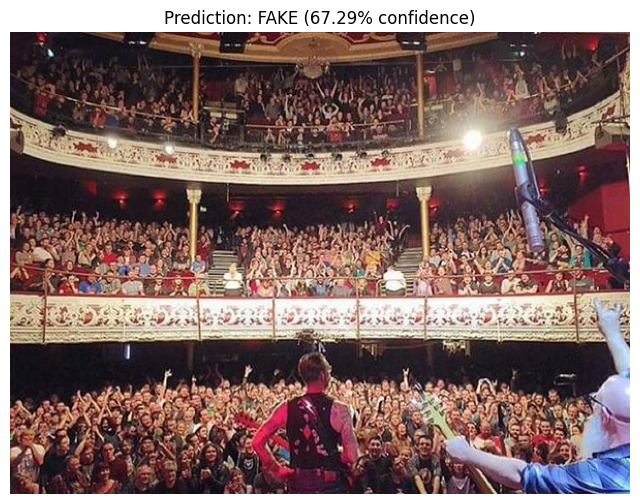

In [98]:
# Example usage
# Replace with your own text and image path

sample_text = "Breaking news: Major event happening now!"
sample_image_path = test_image_paths[0]  # Using first test image as example

result = predict_fake_news(sample_text, sample_image_path, model, tokenizer)

print("\n" + "="*50)
print("PREDICTION RESULT")
print("="*50)
print(f"Text: {result['text']}")
print(f"Image: {result['image_path']}")
print(f"\nPrediction: {result['label']}")
print(f"Confidence: {result['confidence']:.2%}")
print(f"Raw Score: {result['raw_score']:.4f}")
print("="*50)

# Display the image
img = cv2.imread(sample_image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(8, 6))
plt.imshow(img_rgb)
plt.title(f"Prediction: {result['label']} ({result['confidence']:.2%} confidence)")
plt.axis('off')
plt.show()

### Batch Prediction on Multiple Inputs

In [91]:
def predict_batch(texts, image_paths, model, tokenizer, threshold=0.5):
    """
    Make predictions on multiple text-image pairs.
    
    Args:
        texts (list): List of text strings
        image_paths (list): List of image file paths
        model: Trained Keras model
        tokenizer: BERT tokenizer
        threshold (float): Classification threshold
    
    Returns:
        list: List of prediction dictionaries
    """
    results = []
    for text, img_path in tqdm(zip(texts, image_paths), total=len(texts), desc="Making predictions"):
        try:
            result = predict_fake_news(text, img_path, model, tokenizer, threshold)
            results.append(result)
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            results.append({
                'label': 'ERROR',
                'confidence': 0.0,
                'raw_score': 0.0,
                'text': text,
                'image_path': img_path,
                'error': str(e)
            })
    return results

print("✓ Batch prediction function ready")

✓ Batch prediction function ready


In [94]:
# Example: Predict on first 5 test samples
sample_size = 5
sample_texts = test_text[:sample_size]
sample_images = test_image_paths[:sample_size]
sample_labels = testY[:sample_size]

predictions = predict_batch(sample_texts, sample_images, model, tokenizer)

# Display results
print("\n" + "="*80)
print("BATCH PREDICTION RESULTS")
print("="*80)
for i, (pred, true_label) in enumerate(zip(predictions, sample_labels)):
    true_label_str = "REAL" if true_label == 1 else "FAKE"
    match = "✓" if pred['label'] == true_label_str else "✗"
    print(f"\nSample {i+1}:")
    print(f"  Text: {pred['text'][:50]}...")
    print(f"  True Label: {true_label_str}")
    print(f"  Predicted: {pred['label']} ({pred['confidence']:.2%}) {match}")
print("="*80)

Making predictions:   0%|          | 0/5 [00:00<?, ?it/s]


BATCH PREDICTION RESULTS

Sample 1:
  Text: Tristesse...😢🙏 \n#Bataclan sold out, musiciens &am...
  True Label: FAKE
  Predicted: FAKE (64.76%) ✓

Sample 2:
  Text: RT @Proyecto40: #ÚltimaHora Espectacular fotografí...
  True Label: FAKE
  Predicted: FAKE (65.57%) ✓

Sample 3:
  Text: RT @Javivi1976: #Bataclan esta noche antes de los ...
  True Label: FAKE
  Predicted: FAKE (64.26%) ✓

Sample 4:
  Text: RT @Pizzigatas: El hombre tiene que establecer un ...
  True Label: FAKE
  Predicted: FAKE (65.73%) ✓

Sample 5:
  Text: 🇫🇷 #Paris https://t.co/zjjRPC7USm...
  True Label: FAKE
  Predicted: FAKE (67.05%) ✓


## 8. Save/Load Model

In [95]:
# Save the entire model
model.save('spotfake_final_model.h5')
print("✓ Model saved to 'spotfake_final_model.h5'")

# To load the model later:
# loaded_model = tf.keras.models.load_model('spotfake_final_model.h5', custom_objects={'KerasLayer': hub.KerasLayer})

✓ Model saved to 'spotfake_final_model.h5'


## Summary

This notebook provides:

1. **Data Loading & Preprocessing**: Load Twitter fake news dataset with text and images
2. **Model Architecture**: Multimodal model combining BERT (text) + VGG19 (image)
3. **Training**: Train the model with optimal hyperparameters
4. **Evaluation**: Comprehensive metrics on test set
5. **Inference**: Easy-to-use functions for predicting on new inputs

### To use this notebook:

1. Run all cells in order to train the model
2. Use `predict_fake_news()` for single predictions
3. Use `predict_batch()` for multiple predictions
4. Load saved weights with `model.load_weights()` to skip training

### For new predictions:

```python
# Your custom input
my_text = "Your news text here"
my_image = "path/to/your/image.jpg"

# Get prediction
result = predict_fake_news(my_text, my_image, model, tokenizer)
print(f"Prediction: {result['label']} (Confidence: {result['confidence']:.2%})")
```

In [100]:
model.load_weights('spotfake_final_model.h5')


PREDICTION RESULT
Text: RT @welt: Yasmin Fahimi: #Pegida-Organisatoren sind geistige Brandstifter http://t.co/qD2mMrvxTS http://t.co/sMX6wxKKZL
Image: dataset/twitter/images_test/protest_5.jpg

Prediction: FAKE
Confidence: 65.30%
Raw Score: 0.3470


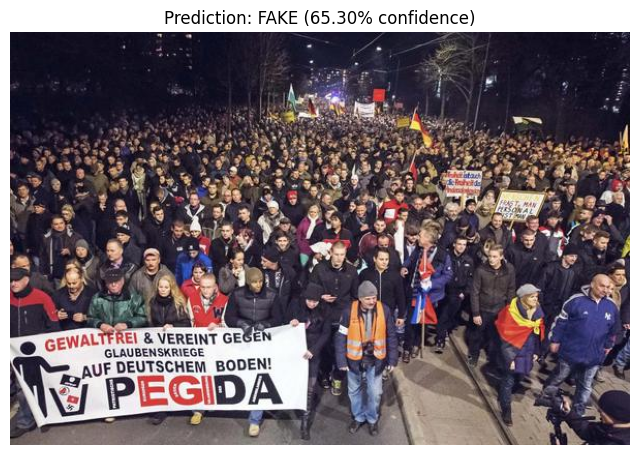

In [101]:
my_text = "RT @welt: Yasmin Fahimi: ""#Pegida-Organisatoren sind geistige Brandstifter"" http://t.co/qD2mMrvxTS http://t.co/sMX6wxKKZL"
# my_text =L'
my_image = "dataset/twitter/images_test/protest_5.jpg"

# Get prediction
result = predict_fake_news(my_text, my_image, model, tokenizer)
print("\n" + "="*50)
print("PREDICTION RESULT")
print("="*50)
print(f"Text: {result['text']}")
print(f"Image: {result['image_path']}")
print(f"\nPrediction: {result['label']}")
print(f"Confidence: {result['confidence']:.2%}")
print(f"Raw Score: {result['raw_score']:.4f}")
print("="*50)

# Display the image
img = cv2.imread(my_image)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(8, 6))
plt.imshow(img_rgb)
plt.title(f"Prediction: {result['label']} ({result['confidence']:.2%} confidence)")
plt.axis('off')
plt.show()

## 9. Comprehensive Test Set Predictions

Script to extract all test data from CSV and run predictions with detailed output.

In [61]:
# Load test data from CSV
print("Loading test data from CSV...")
test_csv = pd.read_csv('dataset/twitter/test_posts.csv')

print(f"Total test samples in CSV: {len(test_csv)}")
print(f"\nColumns: {test_csv.columns.tolist()}")
print(f"\nFirst few rows:")
test_csv.head()

Loading test data from CSV...
Total test samples in CSV: 1091

Columns: ['post_id', 'post_text', 'user_id', 'username', 'image_id', 'timestamp', 'label']

First few rows:


,post_id,post_text,user_id,username,image_id,timestamp,label
0,665333038944002048,"Tristesse...😢🙏 \n#Bataclan sold out, musiciens...",5.547267e+08,Louise_Officiel,attacks_paris_1,Sat Nov 14 00:58:52 +0000 2015,fake
1,665324167785410560,RT @Proyecto40: #ÚltimaHora Espectacular fotog...,2.827010e+09,MarinoCarril,attacks_paris_1,Sat Nov 14 00:23:37 +0000 2015,fake
2,665333370205765632,RT @Javivi1976: #Bataclan esta noche antes de ...,3.776037e+08,MireiaMaroto,attacks_paris_1,Sat Nov 14 01:00:11 +0000 2015,fake
3,665326188735295489,RT @Pizzigatas: El hombre tiene que establecer...,1.102841e+08,maria_cabrera,attacks_paris_1,Sat Nov 14 00:31:39 +0000 2015,fake
4,665389341141659648,🇫🇷 #Paris https://t.co/zjjRPC7USm,1.653118e+07,RaycMolina,attacks_paris_1,Sat Nov 14 04:42:35 +0000 2015,fake


In [62]:
# Extract and prepare data for prediction
def prepare_test_data_from_csv(csv_file, images_folder='dataset/twitter/images_test'):
    """
    Extract text and image paths from test CSV file.
    
    Args:
        csv_file (str): Path to test CSV file
        images_folder (str): Base path to images folder
    
    Returns:
        tuple: (texts, image_paths, labels, image_ids)
    """
    df = pd.read_csv(csv_file)
    
    # Extract first image ID from comma-separated list
    df['first_image_id'] = df['image_id'].apply(lambda x: x.split(',')[0].strip())
    
    # Get image extensions helper
    images = listdir(images_folder)
    jpg, png, jpeg, gif = [], [], [], []
    
    for img in images:
        if '.' not in img or img.startswith('.'):
            continue
        name, ext = img.split('.')[0], img.split('.')[-1].lower()
        if ext == 'jpg':
            jpg.append(name)
        elif ext == 'png':
            png.append(name)
        elif ext == 'jpeg':
            jpeg.append(name)
        elif ext == 'gif':
            gif.append(name)
    
    def get_extension(file_name):
        if file_name in jpg:
            return '.jpg'
        elif file_name in png:
            return '.png'
        elif file_name in jpeg:
            return '.jpeg'
        else:
            return '.gif'
    
    # Build full image paths
    df['image_path'] = df['first_image_id'].apply(
        lambda x: f"{images_folder}/{x}{get_extension(x)}"
    )
    
    # Check which images exist
    df['image_exists'] = df['image_path'].apply(os.path.exists)
    
    # Filter to only existing images
    df_valid = df[df['image_exists']].copy()
    
    print(f"Total samples: {len(df)}")
    print(f"Valid samples with images: {len(df_valid)}")
    print(f"Missing images: {len(df) - len(df_valid)}\")\n")
    
    # Extract data
    texts = df_valid['post_text'].tolist()
    image_paths = df_valid['image_path'].tolist()
    image_ids = df_valid['first_image_id'].tolist()
    
    # Convert labels
    labels = df_valid['label'].apply(lambda x: 1 if x == 'real' else 0).tolist()
    
    return texts, image_paths, labels, image_ids, df_valid

# Prepare test data
test_texts, test_imgs, test_labels, test_ids, test_df_valid = prepare_test_data_from_csv(
    'dataset/twitter/test_posts.csv'
)

print(f"Ready to predict on {len(test_texts)} samples")

Total samples: 1091
Valid samples with images: 1091
Missing images: 0")

Ready to predict on 1091 samples


In [63]:
# Run predictions on all test samples
print("Running predictions on all test samples...")
print("This may take a few minutes...\n")

all_predictions = predict_batch(test_texts, test_imgs, model, tokenizer)

print(f"\n✓ Predictions completed for {len(all_predictions)} samples")

Running predictions on all test samples...
This may take a few minutes...



Making predictions:   0%|          | 0/1091 [00:00<?, ?it/s]


✓ Predictions completed for 1091 samples


In [64]:
# Create comprehensive results DataFrame
results_df = pd.DataFrame({
    'image_id': test_ids,
    'text': test_texts,
    'image_path': test_imgs,
    'true_label': ['REAL' if l == 1 else 'FAKE' for l in test_labels],
    'predicted_label': [p['label'] for p in all_predictions],
    'confidence': [p['confidence'] for p in all_predictions],
    'raw_score': [p['raw_score'] for p in all_predictions],
    'correct': [p['label'] == ('REAL' if l == 1 else 'FAKE') for p, l in zip(all_predictions, test_labels)]
})

# Add numeric labels for metrics
results_df['true_label_numeric'] = results_df['true_label'].apply(lambda x: 1 if x == 'REAL' else 0)
results_df['predicted_label_numeric'] = results_df['predicted_label'].apply(lambda x: 1 if x == 'REAL' else 0)

print("Results DataFrame created successfully!")
print(f"Total predictions: {len(results_df)}")
results_df.head(10)

Results DataFrame created successfully!
Total predictions: 1091


,image_id,text,image_path,true_label,predicted_label,confidence,raw_score,correct,true_label_numeric,predicted_label_numeric
0,attacks_paris_1,"Tristesse...😢🙏 \n#Bataclan sold out, musiciens...",dataset/twitter/images_test/attacks_paris_1.jpg,FAKE,FAKE,0.647593,0.352407,True,0,0
1,attacks_paris_1,RT @Proyecto40: #ÚltimaHora Espectacular fotog...,dataset/twitter/images_test/attacks_paris_1.jpg,FAKE,FAKE,0.655689,0.344312,True,0,0
2,attacks_paris_1,RT @Javivi1976: #Bataclan esta noche antes de ...,dataset/twitter/images_test/attacks_paris_1.jpg,FAKE,FAKE,0.642632,0.357368,True,0,0
3,attacks_paris_1,RT @Pizzigatas: El hombre tiene que establecer...,dataset/twitter/images_test/attacks_paris_1.jpg,FAKE,FAKE,0.657270,0.342730,True,0,0
4,attacks_paris_1,🇫🇷 #Paris https://t.co/zjjRPC7USm,dataset/twitter/images_test/attacks_paris_1.jpg,FAKE,FAKE,0.670535,0.329465,True,0,0
5,attacks_paris_1,RT @Soy_Donante: #EaglesOfDeathMetal antes del...,dataset/twitter/images_test/attacks_paris_1.jpg,FAKE,FAKE,0.665233,0.334767,True,0,0
6,attacks_paris_1,Foto Antes Del Atentato En El Bacatlan \n#Pari...,dataset/twitter/images_test/attacks_paris_1.jpg,FAKE,FAKE,0.681633,0.318367,True,0,0
7,attacks_paris_1,RT @anaidmartinezm: Foto Antes Del Atentato En...,dataset/twitter/images_test/attacks_paris_1.jpg,FAKE,FAKE,0.649884,0.350116,True,0,0
8,attacks_paris_1,RT @marcelomena: Esta foto se tomó al inicio d...,dataset/twitter/images_test/attacks_paris_1.jpg,FAKE,FAKE,0.656611,0.343389,True,0,0
9,attacks_paris_1,Işte o konser salonu! Teröristler ellerinde uz...,dataset/twitter/images_test/attacks_paris_1.jpg,FAKE,FAKE,0.682247,0.317753,True,0,0


In [65]:
# Calculate comprehensive metrics
from sklearn.metrics import classification_report, confusion_matrix

print("="*80)
print("COMPREHENSIVE TEST SET EVALUATION")
print("="*80)

# Overall accuracy
accuracy = accuracy_score(results_df['true_label_numeric'], results_df['predicted_label_numeric'])
print(f"\n📊 Overall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Correct vs incorrect predictions
correct_count = results_df['correct'].sum()
incorrect_count = len(results_df) - correct_count
print(f"✓ Correct predictions: {correct_count}/{len(results_df)}")
print(f"✗ Incorrect predictions: {incorrect_count}/{len(results_df)}")

# Per-class metrics
print(f"\n📈 Detailed Classification Report:")
print(classification_report(
    results_df['true_label_numeric'], 
    results_df['predicted_label_numeric'],
    target_names=['FAKE', 'REAL'],
    digits=4
))

# Confusion matrix
cm = confusion_matrix(results_df['true_label_numeric'], results_df['predicted_label_numeric'])
print(f"🔢 Confusion Matrix:")
print(f"                 Predicted")
print(f"                 FAKE  REAL")
print(f"Actual  FAKE     {cm[0][0]:4d}  {cm[0][1]:4d}")
print(f"        REAL     {cm[1][0]:4d}  {cm[1][1]:4d}")

# Confidence statistics
print(f"\n📉 Confidence Statistics:")
print(f"Mean confidence: {results_df['confidence'].mean():.4f}")
print(f"Median confidence: {results_df['confidence'].median():.4f}")
print(f"Min confidence: {results_df['confidence'].min():.4f}")
print(f"Max confidence: {results_df['confidence'].max():.4f}")

print(f"\nConfidence for correct predictions: {results_df[results_df['correct']]['confidence'].mean():.4f}")
print(f"Confidence for incorrect predictions: {results_df[~results_df['correct']]['confidence'].mean():.4f}")

print("="*80)

COMPREHENSIVE TEST SET EVALUATION

📊 Overall Accuracy: 0.6251 (62.51%)
✓ Correct predictions: 682/1091
✗ Incorrect predictions: 409/1091

📈 Detailed Classification Report:
              precision    recall  f1-score   support

        FAKE     0.6037    1.0000    0.7529       623
        REAL     1.0000    0.1261    0.2239       468

    accuracy                         0.6251      1091
   macro avg     0.8018    0.5630    0.4884      1091
weighted avg     0.7737    0.6251    0.5260      1091

🔢 Confusion Matrix:
                 Predicted
                 FAKE  REAL
Actual  FAKE      623     0
        REAL      409    59

📉 Confidence Statistics:
Mean confidence: 0.6838
Median confidence: 0.6691
Min confidence: 0.5959
Max confidence: 1.0000

Confidence for correct predictions: 0.6941
Confidence for incorrect predictions: 0.6666


In [66]:
# Display sample predictions (first 20)
print("="*100)
print("SAMPLE PREDICTIONS (First 20)")
print("="*100)

for idx in range(min(20, len(results_df))):
    row = results_df.iloc[idx]
    match_symbol = "✓" if row['correct'] else "✗"
    
    print(f"\n[{idx+1}] {match_symbol} Image: {row['image_id']}")
    print(f"    Text: {row['text'][:80]}...")
    print(f"    True Label: {row['true_label']} | Predicted: {row['predicted_label']} | Confidence: {row['confidence']:.2%}")
    print(f"    Raw Score: {row['raw_score']:.4f}")

print("\n" + "="*100)

SAMPLE PREDICTIONS (First 20)

[1] ✓ Image: attacks_paris_1
    Text: Tristesse...😢🙏 \n#Bataclan sold out, musiciens &amp; public en osmose...Quelques...
    True Label: FAKE | Predicted: FAKE | Confidence: 64.76%
    Raw Score: 0.3524

[2] ✓ Image: attacks_paris_1
    Text: RT @Proyecto40: #ÚltimaHora Espectacular fotografía sacada antes de los ataques ...
    True Label: FAKE | Predicted: FAKE | Confidence: 65.57%
    Raw Score: 0.3443

[3] ✓ Image: attacks_paris_1
    Text: RT @Javivi1976: #Bataclan esta noche antes de los atentados. @playradiovlc https...
    True Label: FAKE | Predicted: FAKE | Confidence: 64.26%
    Raw Score: 0.3574

[4] ✓ Image: attacks_paris_1
    Text: RT @Pizzigatas: El hombre tiene que establecer un final para la guerra. Sino, és...
    True Label: FAKE | Predicted: FAKE | Confidence: 65.73%
    Raw Score: 0.3427

[5] ✓ Image: attacks_paris_1
    Text: 🇫🇷 #Paris https://t.co/zjjRPC7USm...
    True Label: FAKE | Predicted: FAKE | Confidence: 67.05%
    Raw S

In [67]:
# Show incorrect predictions for analysis
incorrect_predictions = results_df[~results_df['correct']]

if len(incorrect_predictions) > 0:
    print("="*100)
    print(f"INCORRECT PREDICTIONS ({len(incorrect_predictions)} total)")
    print("="*100)
    
    for idx, (_, row) in enumerate(incorrect_predictions.head(15).iterrows()):
        print(f"\n[{idx+1}] ✗ Image: {row['image_id']}")
        print(f"    Text: {row['text'][:80]}...")
        print(f"    True: {row['true_label']} | Predicted: {row['predicted_label']} | Confidence: {row['confidence']:.2%}")
        print(f"    Raw Score: {row['raw_score']:.4f}")
    
    if len(incorrect_predictions) > 15:
        print(f"\n... and {len(incorrect_predictions) - 15} more incorrect predictions")
    
    print("\n" + "="*100)
else:
    print("\n🎉 Perfect predictions! All samples classified correctly!")

INCORRECT PREDICTIONS (409 total)

[1] ✗ Image: attacks_paris_10
    Text: RT @Conflicts: PHOTO: French military deployed on the streets of #Paris as a lar...
    True: REAL | Predicted: FAKE | Confidence: 65.00%
    Raw Score: 0.3500

[2] ✗ Image: attacks_paris_10
    Text: RT @J0nDeFrance: L'armée déployée à Paris https://t.co/eyyZqIMevk...
    True: REAL | Predicted: FAKE | Confidence: 67.07%
    Raw Score: 0.3293

[3] ✗ Image: attacks_paris_10
    Text: Attentats ah il reste deux militaires disponibles  à Paris https://t.co/FjRT1SOU...
    True: REAL | Predicted: FAKE | Confidence: 68.19%
    Raw Score: 0.3181

[4] ✗ Image: attacks_paris_10
    Text: RT @saserief: “@Conflicts:  French military deployed on the streets of #Paris  l...
    True: REAL | Predicted: FAKE | Confidence: 67.18%
    Raw Score: 0.3282

[5] ✗ Image: attacks_paris_10
    Text: “@Conflicts:  French military deployed on the streets of #Paris  large scale ter...
    True: REAL | Predicted: FAKE | Confidence: 65.81

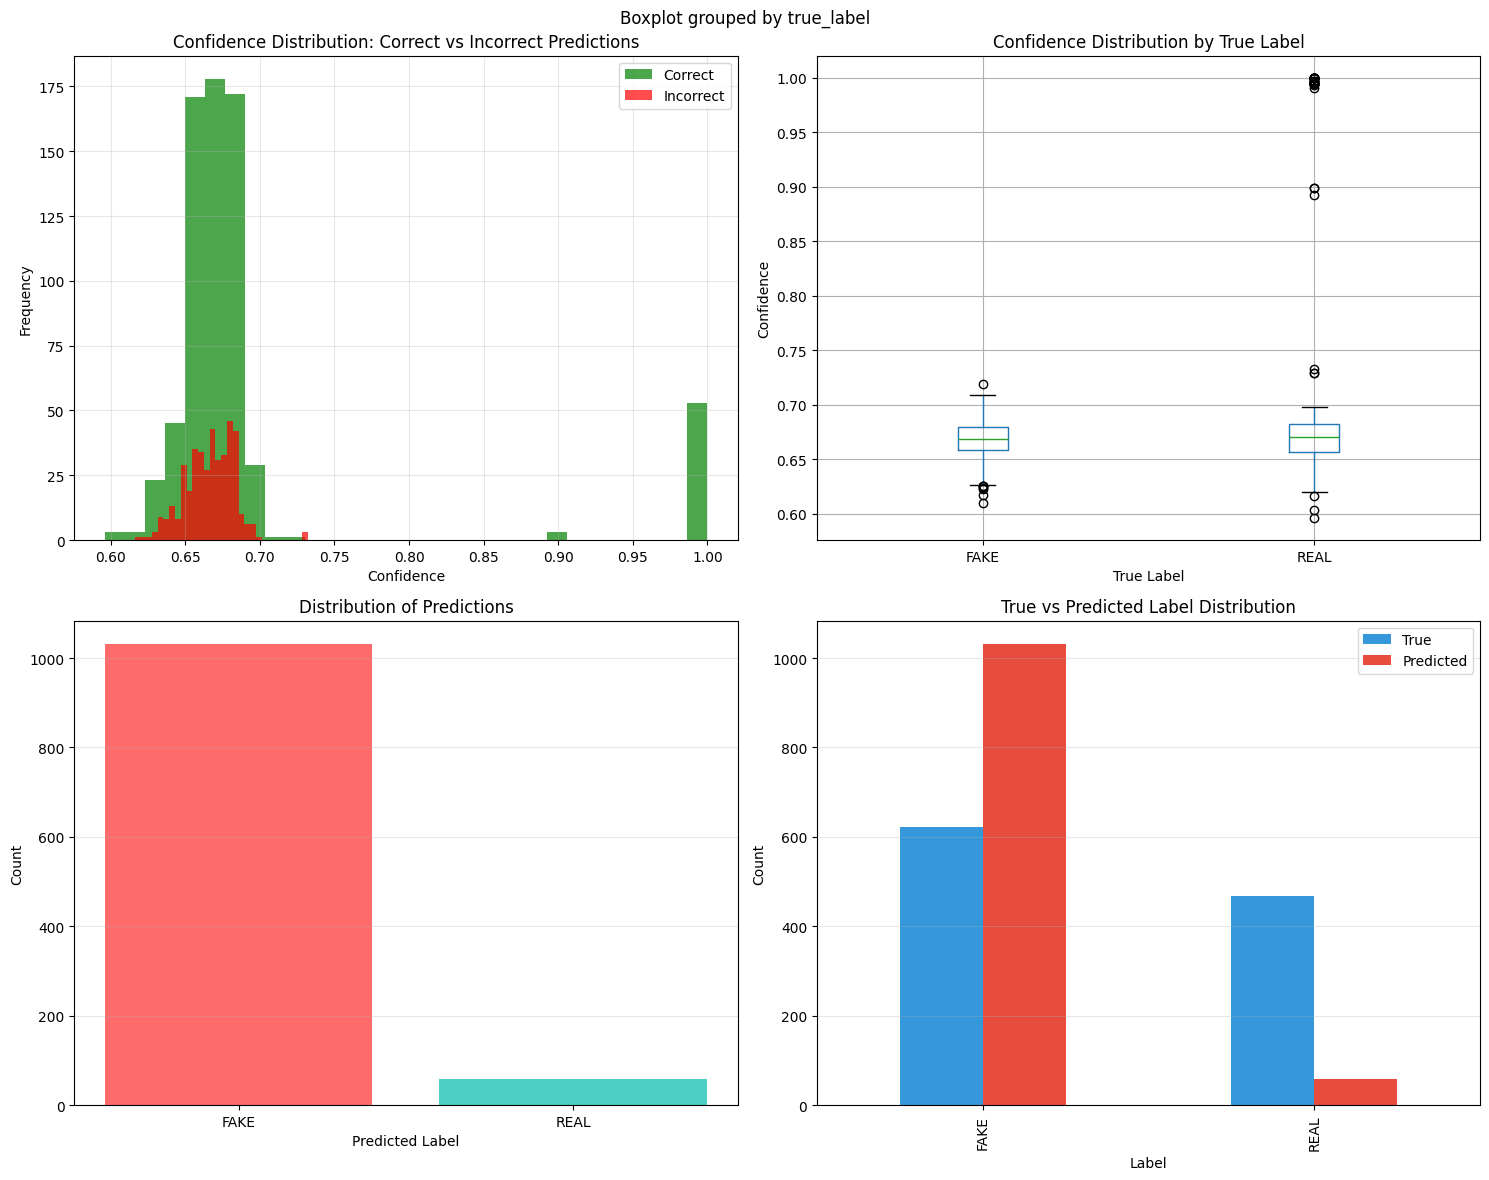

✓ Visualizations generated


In [68]:
# Visualize confidence distribution
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Confidence distribution for correct vs incorrect
ax1 = axes[0, 0]
results_df[results_df['correct']]['confidence'].hist(bins=30, alpha=0.7, label='Correct', ax=ax1, color='green')
results_df[~results_df['correct']]['confidence'].hist(bins=30, alpha=0.7, label='Incorrect', ax=ax1, color='red')
ax1.set_xlabel('Confidence')
ax1.set_ylabel('Frequency')
ax1.set_title('Confidence Distribution: Correct vs Incorrect Predictions')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Confidence by true label
ax2 = axes[0, 1]
results_df.boxplot(column='confidence', by='true_label', ax=ax2)
ax2.set_xlabel('True Label')
ax2.set_ylabel('Confidence')
ax2.set_title('Confidence Distribution by True Label')
plt.sca(ax2)
plt.xticks(rotation=0)

# 3. Prediction distribution
ax3 = axes[1, 0]
pred_counts = results_df['predicted_label'].value_counts()
ax3.bar(pred_counts.index, pred_counts.values, color=['#ff6b6b', '#4ecdc4'])
ax3.set_xlabel('Predicted Label')
ax3.set_ylabel('Count')
ax3.set_title('Distribution of Predictions')
ax3.grid(True, alpha=0.3, axis='y')

# 4. True vs Predicted distribution
ax4 = axes[1, 1]
comparison = pd.DataFrame({
    'True': results_df['true_label'].value_counts(),
    'Predicted': results_df['predicted_label'].value_counts()
})
comparison.plot(kind='bar', ax=ax4, color=['#3498db', '#e74c3c'])
ax4.set_xlabel('Label')
ax4.set_ylabel('Count')
ax4.set_title('True vs Predicted Label Distribution')
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

print("✓ Visualizations generated")

In [69]:
# Save results to CSV
output_filename = 'test_predictions_results.csv'
results_df.to_csv(output_filename, index=False)

print(f"✓ Results saved to '{output_filename}'")
print(f"\nColumns in saved file:")
for col in results_df.columns:
    print(f"  - {col}")

print(f"\nFile contains {len(results_df)} predictions")
print(f"Location: {os.path.abspath(output_filename)}")

✓ Results saved to 'test_predictions_results.csv'

Columns in saved file:
  - image_id
  - text
  - image_path
  - true_label
  - predicted_label
  - confidence
  - raw_score
  - correct
  - true_label_numeric
  - predicted_label_numeric

File contains 1091 predictions
Location: e:\RP\SpotFake02\test_predictions_results.csv


In [ ]:
# Summary statistics by category
print("="*80)
print("PERFORMANCE SUMMARY BY CATEGORY")
print("="*80)

# By true label
print("\n📊 Performance by True Label:")
for label in ['FAKE', 'REAL']:
    subset = results_df[results_df['true_label'] == label]
    correct = subset['correct'].sum()
    total = len(subset)
    accuracy = correct / total if total > 0 else 0
    avg_conf = subset['confidence'].mean()
    
    print(f"\n  {label}:")
    print(f"    Total samples: {total}")
    print(f"    Correct: {correct} ({accuracy*100:.2f}%)")
    print(f"    Average confidence: {avg_conf:.4f}")

# High vs low confidence predictions
print("\n📊 Performance by Confidence Level:")
high_conf = results_df[results_df['confidence'] >= 0.7]
low_conf = results_df[results_df['confidence'] < 0.7]

print(f"\n  High Confidence (≥70%):")
print(f"    Count: {len(high_conf)}")
print(f"    Accuracy: {high_conf['correct'].sum() / len(high_conf) * 100:.2f}%")

print(f"\n  Low Confidence (<70%):")
print(f"    Count: {len(low_conf)}")
print(f"    Accuracy: {low_conf['correct'].sum() / len(low_conf) * 100:.2f}%" if len(low_conf) > 0 else "    No samples")

print("\n" + "="*80)

In [ ]:
# Interactive search function
def search_prediction(image_id=None, text_keyword=None):
    """
    Search predictions by image ID or text keyword.
    
    Args:
        image_id (str): Image ID to search for
        text_keyword (str): Keyword to search in text
    """
    if image_id:
        matches = results_df[results_df['image_id'].str.contains(image_id, case=False)]
    elif text_keyword:
        matches = results_df[results_df['text'].str.contains(text_keyword, case=False, na=False)]
    else:
        print("Please provide either image_id or text_keyword")
        return
    
    if len(matches) == 0:
        print("No matches found")
        return
    
    print(f"Found {len(matches)} match(es):\n")
    for idx, (_, row) in enumerate(matches.iterrows()):
        match_symbol = "✓" if row['correct'] else "✗"
        print(f"[{idx+1}] {match_symbol} Image: {row['image_id']}")
        print(f"    Text: {row['text'][:100]}...")
        print(f"    True: {row['true_label']} | Predicted: {row['predicted_label']}")
        print(f"    Confidence: {row['confidence']:.2%} | Raw Score: {row['raw_score']:.4f}")
        print()

# Example usage
print("Search Function Ready!")
print("\nExample usage:")
print("  search_prediction(image_id='paris')")
print("  search_prediction(text_keyword='terror')")
print("\nTry it yourself below:")